In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd /home/asehgal/neurosym-lib

import json
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, f1_score, hamming_loss, roc_curve

import neurosym as ns
from neurosym.examples import near
from neurosym.examples.near import ValidationCost

# LIST_LENGTH = 10

/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/asehgal/neurosym-lib


In [2]:
def bce_loss(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Compute the binary cross entropy loss with class weights for the Tiny CalMS21 dataset.
    This is the same loss function used in the base NEAR implementation.

    Args:
        predictions (torch.Tensor): Model predictions with shape (B, T, O).
        targets (torch.Tensor): Ground truth labels with shape (B, T, 1).

    Returns:
        torch.Tensor: The computed binary cross-entropy loss.
    """
    targets = targets.squeeze(-1)  # (B, T, 1) -> (B, T)
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view_as(predictions)
    return torch.nn.functional.binary_cross_entropy_with_logits(
        predictions.float(),
        targets.float(),
        weight=torch.tensor([2.0], device=predictions.device),
    )


def threshold_predictions(
    y_true: torch.Tensor, y_scores: torch.Tensor, threshold_type: str = "quantile"
) -> torch.Tensor:
    if threshold_type == "quantile":
        threshold = np.quantile(y_scores, 1 - y_true.float().mean())
    elif threshold_type == "roc":
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        threshold = thresholds[np.argmax(tpr - fpr)]
    elif threshold_type == "static":
        threshold = 0.5
    else:
        raise ValueError(f"Unknown threshold type: {threshold_type}")
    predictions = (torch.sigmoid(y_scores) < threshold).int()
    return predictions


def compute_near_metrics(predictions: np.array, ground_truth: np.array):
    predictions = (
        threshold_predictions(
            torch.tensor(ground_truth, dtype=torch.float32),
            torch.tensor(predictions, dtype=torch.float32),
            threshold_type="quantile",
        )
        .numpy()
        .flatten()
    )
    ground_truth = ground_truth.flatten()

    try:
        weighted_avg_f1 = f1_score(predictions, ground_truth, average="weighted")
        unweighted_avg_f1 = f1_score(predictions, ground_truth, average="macro")
        all_f1 = f1_score(predictions, ground_truth, average=None)
        hamming_accuracy = 1 - hamming_loss(ground_truth, predictions)
    except ValueError as e:
        print(f"Error computing metrics: {e}")
        weighted_avg_f1 = 0.0
        unweighted_avg_f1 = 0.0
        all_f1 = []
        hamming_accuracy = 0.0
    report = classification_report(ground_truth, predictions, output_dict=True)
    return dict(
        f1_score=weighted_avg_f1,
        unweighted_f1=unweighted_avg_f1,
        all_f1s=all_f1,
        hamming_accuracy=hamming_accuracy,
        report=report,
    )


def eval_program(module, feature_data, labels):
    predictions = (
        module(torch.tensor(feature_data), environment=()).detach().numpy().flatten()
    )
    metrics = compute_near_metrics(predictions, labels)
    return metrics, predictions


In [3]:
class DisjointValidationCost(ValidationCost):
    @classmethod
    def from_validation_cost(cls, validation_cost):
        return cls(
            trainer_cfg=validation_cost.trainer_cfg,
            datamodule=validation_cost.datamodule,
            progress_by_epoch=validation_cost.progress_by_epoch,
            n_epochs=validation_cost.n_epochs,
        )

    def compute_cost(self, dsl, model, embedding):
        _ = super().compute_cost(dsl, model, embedding)
        if not isinstance(model, torch.nn.Module):
            raise TypeError(
                f"Expected model to be a torch.nn.Module, got {type(model)} instead."
            )
        # model = self.program_to_module(dsl, model, embedding)

        labels = []
        predictions = []
        for batch in self.datamodule.val_dataloader():
            batch = {k: v.to(self.trainer_cfg.accelerator) for k, v in batch.items()}
            x, y = batch["inputs"], batch["outputs"]
            pred_y = model(x, environment=())
            predictions.append(pred_y)
            labels.append(y)

        labels = torch.cat(labels, dim=0)
        predictions = torch.cat(predictions, dim=0).detach()
        predictions = threshold_predictions(
            y_true=labels.cpu().clone(),
            y_scores=predictions.cpu(),
            threshold_type="quantile",
        )

        # compute hamming loss
        loss = 1 - hamming_loss(
            labels.cpu().numpy().flatten().astype(int),
            predictions.cpu().numpy().flatten(),
        )
        return loss

In [ ]:
def run_crim13_experiment(
    output_path: str = "outputs/compression_near_logs/crim13_results.pkl",
):
    """
    Run the NEAR experiment on the CRIM13 dataset.

    Args:
        output_path (str): File path to save the resulting programs list as a pickle file.
    """

    # Prepare data and DSL
    hidden_dim = 1
    datamodule = ns.datasets.crim13_data_example(train_seed=0, batch_size=1024)
    # _, output_dim = datamodule.train.get_io_dims(is_regression=True)
    output_dim = 1
    original_dsl = near.simple_crim13_dsl(num_classes=output_dim, hidden_dim=hidden_dim)

    # Trainer configuration
    trainer_cfg = near.NEARTrainerConfig(
        n_epochs=15, lr=1e-3, loss_callback=bce_loss, accelerator="cuda:0"
    )

    neural_dsl = near.NeuralDSL.from_dsl(
        dsl=original_dsl,
        neural_hole_filler=near.GenericMLPRNNNeuralHoleFiller(hidden_size=32),
    )

    cost = near.default_near_cost(
        trainer_cfg=trainer_cfg,
        datamodule=datamodule,
        structural_cost_weight=0.005,
    )
    cast(near.ValidationCost, cost.validation_heuristic)

    # Create the NEAR graph
    g = near.near_graph(
        neural_dsl,
        neural_dsl.valid_root_types[0],
        is_goal=lambda _: True,
        cost=cost,
    )

    # Search for programs with bounded A*
    iterator = ns.search.BoundedAStar(max_depth=10)(g)

    programs_list = []
    start_time = time.time()

    # Collect programs up to LIST_LENGTH
    while True:
        try:
            program = next(iterator)
        except StopIteration:
            break

        timer = time.time() - start_time
        programs_list.append({"program": program, "time": timer})

        if len(programs_list) >= LIST_LENGTH:
            print("Programs list is too long")
            break

    # Optional: Drop into an interactive shell (commented out for module usage)
    # save the program list
    with open(output_path.replace(".pkl", "_raw.pkl"), "wb") as f:
        pickle.dump(programs_list, f)

    # Print the number of programs found
    print(
        f"Found {len(programs_list)} programs in {time.time() - start_time:.2f} seconds."
    )

    # Evaluate each discovered program
    for d in programs_list:
        program = d["program"]
        initialized_program = neural_dsl.initialize(program)
        _ = cost.validation_heuristic.with_n_epochs(40).compute_cost(
            neural_dsl, initialized_program, cost.embedding
        )

        feature_data = datamodule.test.inputs
        labels = datamodule.test.outputs.flatten()

        module = ns.examples.near.TorchProgramModule(neural_dsl, initialized_program)
        metrics, predictions = eval_program(module, feature_data, labels)
        d["report"] = metrics
        d["true_vals"] = labels.tolist()
        d["pred_vals"] = predictions.tolist()

    # Save the progr/ams_list to a pickle file
    with open(output_path, "wb") as f:
        pickle.dump(programs_list, f)

In [6]:
# # Long runnning processes: run these commands from notebooks/benchmark_mice.py
# %cd /home/asehgal/neurosym-lib
# run_crim13_experiment("outputs/mice_results/expt4-redo.pkl")

In [ ]:
hidden_dim = 1
datamodule = ns.datasets.crim13_data_example(train_seed=0, batch_size=1024)
# _, output_dim = datamodule.train.get_io_dims(is_regression=True)
output_dim = 1
original_dsl = near.simple_crim13_dsl(num_classes=output_dim, hidden_dim=hidden_dim)

# Trainer configuration
trainer_cfg = near.NEARTrainerConfig(
    n_epochs=15,
    lr=1e-4,
    loss_callback=bce_loss,
    accelerator="cuda:0",
)

neural_dsl = near.NeuralDSL.from_dsl(
    dsl=original_dsl,
    neural_hole_filler=near.GenericMLPRNNNeuralHoleFiller(hidden_size=hidden_dim),
)

cost = near.default_near_cost(
    trainer_cfg=trainer_cfg,
    datamodule=datamodule,
    structural_cost_weight=0.005,
)
# cost.validation_heuristic = DisjointValidationCost.from_validation_cost(cost.validation_heuristic)

# Create the NEAR graph
g = near.near_graph(
    neural_dsl,
    neural_dsl.valid_root_types[0],
    is_goal=lambda _: True,
    cost=cost,
)


with open("outputs/mice_results/expt4-fastagg-redo.pkl", "rb") as f:
    programs_list = pickle.load(f)


def train_module_parallel_worker(program_str, neural_dsl, cost, datamodule):
    initialized_program = neural_dsl.initialize(program_str)
    _ = cost.validation_heuristic.with_n_epochs(40).compute_cost(
        neural_dsl, initialized_program, cost.embedding
    )

    feature_data = datamodule.test.inputs
    labels = datamodule.test.outputs.flatten()
    module = ns.examples.near.TorchProgramModule(neural_dsl, initialized_program)
    # Evaluate the program
    metrics, pred_vals = eval_program(module, feature_data, labels)

    return {
        "report": metrics,
        "true_vals": labels.tolist(),
        "pred_vals": pred_vals.tolist(),
    }


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [
        executor.submit(
            train_module_parallel_worker, prog["program"], neural_dsl, cost, datamodule
        )
        for prog in programs_list
    ]

    for i, future in enumerate(futures):
        try:
            result = future.result()
            programs_list[i].update(result)
        except Exception as e:
            print(f"Error processing program {i}: {e}")


# for i, prog in enumerate(programs_list):
#     prog_str = prog['program']
#     initialized_program = neural_dsl.initialize(prog_str)
#     _ = cost.validation_heuristic.with_n_epochs(40).compute_cost(
#         neural_dsl, initialized_program, cost.embedding
#     )

#     feature_data = datamodule.test.inputs
#     labels = datamodule.test.outputs.flatten()

#     module = ns.examples.near.TorchProgramModule(neural_dsl, initialized_program)
#     # Evaluate the program
#     metrics, pred_vals = eval_program(
#         module,
#         feature_data,
#         labels
#     )

#     programs_list[i]['report'] = metrics
#     programs_list[i]['true_vals'] = labels.tolist()
#     programs_list[i]['pred_vals'] = pred_vals.tolist()


/home/asehgal/neurosym-lib/neurosym/dsl/dsl_factory.py:139: DeprecationWarning: The method parameterized is deprecated. Use production instead.
  warnings.warn(
/home/asehgal/neurosym-lib/neurosym/dsl/dsl_factory.py:123: DeprecationWarning: The method concrete is deprecated. Use production instead.
  warnings.warn(


Training (map (affine_position))
Training (map (affine_bool_position))
Training (map (affine_bool_angle_change))
Training (map (affine_angle_change))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Training (map (affine_angle))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Training (map (affine_bool_angle))
Training (map (affine_bool_acceleration))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training (map (affine_bool_velocity))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Training (map (affine_distance))
Training (map (affine_distance_change))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [ ]:
%cd /home/asehgal/neurosym-lib


def bce_loss_flattened(
    predictions: torch.Tensor, targets: torch.Tensor
) -> torch.Tensor:
    """
    Compute the binary cross entropy loss with class weights for the Tiny CalMS21 dataset.
    This is the same loss function used in the base NEAR implementation.

    Args:
        predictions (torch.Tensor): Model predictions with shape (B, T, O).
        targets (torch.Tensor): Ground truth labels with shape (B, T, 1).

    Returns:
        torch.Tensor: The computed binary cross-entropy loss.
    """
    # if predictions.shape[-1] == 1:
    #     fpr, tpr, thresholds = roc_curve(targets.cpu().numpy(), predictions.cpu().numpy())
    #     threshold = thresholds[np.argmax(tpr - fpr)]
    #     predictions = (torch.sigmoid(predictions) < threshold).int()

    targets = targets.squeeze(-1)  # (B, T, 1) -> (B, T)
    predictions = predictions.squeeze(-1)
    # pylint: disable=not-callable
    # pylint: enable=not-callable
    return torch.nn.functional.binary_cross_entropy_with_logits(
        predictions.float(),
        targets.float(),
        weight=torch.tensor([1.5], device=predictions.device),
    )


weights = [
    {
        "weight": torch.tensor([0.0217]),
        "bias": torch.tensor([-0.2785]),
    },
    {
        "weight": torch.tensor([-0.0007, 0.0055, 0.0051, -0.0025]),
        "bias": torch.tensor([3.7426]),
    },
    {
        "weight": torch.tensor([-0.2143]),
        "bias": torch.tensor([1.822]),
    },
]

datamodule = ns.datasets.crim13_data_example(train_seed=0, batch_size=1024)
_, output_dim = datamodule.train.get_io_dims()
original_dsl = near.simple_crim13_dsl(num_classes=1, hidden_dim=1)
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=original_dsl,
    neural_hole_filler=near.GenericMLPRNNNeuralHoleFiller(hidden_size=1),
)
cost = near.default_near_cost(
    trainer_cfg=near.NEARTrainerConfig(
        n_epochs=15,
        lr=1e-3,
        loss_callback=bce_loss_flattened,
    ),
    datamodule=datamodule,
    structural_cost_weight=0.005,
)
# cost.validation_heuristic = DisjointValidationCost.from_validation_cost(cost.validation_heuristic)

program_str = (
    "(map (ite (affine_bool_distance) (affine_acceleration) (affine_distance)))"
)
program = ns.parse_s_expression(program_str)
initialized_program = neural_dsl.initialize(program)
# module = ns.examples.near.TorchProgramModule(original_dsl, initialized_program)
_ = cost.validation_heuristic.with_n_epochs(40).compute_cost(
    neural_dsl, initialized_program, cost.embedding
)
feature_data = datamodule.test.inputs
labels = datamodule.test.outputs.flatten()

module = ns.examples.near.TorchProgramModule(neural_dsl, initialized_program)
_, raw_predictions = eval_program(module, feature_data, labels)
# fpr, tpr, thresholds = roc_curve(labels, raw_predictions)
# threshold = thresholds[np.argmax(tpr - fpr)]
# pred_vals = (torch.sigmoid(torch.tensor(raw_predictions)) < threshold).int().tolist()

reported_metrics = dict(
    true_vals=labels.tolist(),
    pred_vals=raw_predictions,
    report=compute_near_metrics(np.array(raw_predictions), np.array(labels)),
)

/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/home/asehgal/neurosym-lib/neurosym/dsl/dsl_factory.py:139: DeprecationWarning: The method parameterized is deprecated. Use production instead.
  warnings.warn(
/home/asehgal/neurosym-lib/neurosym/dsl/dsl_factory.py:123: DeprecationWarning: The method concrete is deprecated. Use production instead.
  warnings.warn(


/home/asehgal/neurosym-lib
Training (map (ite (affine_bool_distance) (affine_acceleration) (affine_distance)))


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [7]:
def load_obj(file_path: str) -> object:
    """Load an object from a JSON or pickle file."""
    path = Path(file_path)
    if path.suffix == ".json":
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    elif path.suffix == ".pkl":
        with path.open("rb") as f:
            return pickle.load(f)
    else:
        raise ValueError(f"Unsupported file extension: {path.suffix}")


def collect_baseline_results(
    results_dir="/home/asehgal/NEAR/near/near_code/results",
    output_file="outputs/mice_results/baseline_results.json",
):
    final_results = dict()
    for expt_name in os.listdir(results_dir):
        if "crim" not in expt_name:
            continue
        if "11" not in expt_name:
            continue
        results_pth = os.path.join(results_dir, expt_name, "test_results.json")
        if not os.path.exists(results_pth):
            continue
        print(expt_name)
        expt_results = load_obj(results_pth)
        # save final_results to baseline_results.json
        final_results[expt_name] = expt_results
    with open(output_file, "w") as f:
        json.dump(final_results, f, indent=4)


collect_baseline_results(
    results_dir="/home/asehgal/NEAR/near/near_code/results",
    output_file="outputs/mice_results/baseline_results.json",
)

baseline_results = load_obj("outputs/mice_results/baseline_results.json")

crim13_astar-near_011


In [16]:
# baseline_results['crim13_astar-near_010']['predicted_vals']

In [8]:
# correct baseline results
def correct_baseline_results(results):
    for i, (expt_name, expt_report) in enumerate(results.items()):
        # flip the predictions
        # d['pred_vals'] = [1 if x == 0 else 0 for x in d['pred_vals']]
        # expt_report['pred_vals'] = [1 if x == 0 else 0 for x in expt_report['pred_vals']]
        y_true = expt_report["true_vals"]
        y_scores = expt_report["predicted_vals"]
        # np.quantile(y_scores, 1 - y_trues.mean())
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        threshold = thresholds[np.argmax(tpr - fpr)]

        expt_report["pred_vals"] = (
            (torch.sigmoid(torch.tensor(expt_report["predicted_vals"])) < threshold)
            .int()
            .tolist()
        )

        expt_report["report"] = compute_near_metrics(
            predictions=np.array(expt_report["pred_vals"]),
            ground_truth=np.array(expt_report["true_vals"]),
        )
        expt_report["report"]["time"] = expt_report["time"]
        # results[i] = d
    return results


baseline_results = correct_baseline_results(baseline_results)
# our_results = load_obj("outputs/mice_results/crim13_results_3.pkl")
our_results = programs_list
our_results = {
    f"crim13_ours_astar-near_00{i}": our_results[i] for i in range(len(our_results))
}
all_results = {
    **baseline_results,
    **our_results,
    **dict(reported_program=reported_metrics),
}


/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [19]:
# Code is replicating the results from the paper.
# what happens if we manually code in the particular thing in the paper and see if it gets the score if the paper reports for it.
# What if the paper had something that was good, due to changing versions we are comparing against a worse baseline.

In [20]:
# k = "reported_program"
# p = torch.sigmoid(outputs).detach().numpy()
# t = np.array(all_results[k]['true_vals']).reshape(outputs.shape)
# threshold = np.quantile(p, 1 - (t == 1).mean())
# print(threshold) # -0.610755115272512
# overlap = ((p > threshold) & (t == 1)).mean() / (t == 1).mean()
# print(overlap) # 0.6761173584785448

In [ ]:
# print("{name:28} {overlap:>5} {t:>6} {p:>10} {total:>5}".format(
#     name="Program",
#     overlap="overlap",
#     t="true",
#     p="pred",
#     total="total"
# ))
# for k in all_results.keys():
#     t = np.array(all_results[k]['true_vals'])
#     p = np.array(all_results[k]['pred_vals'])
#     overlap = (t == 1) & (p == 1)

#     # use formatted string for this
#     print("{name:30} {overlap:>5} {t:>6} {p:>10} {total:>5}".format(
#         name=k[-30:],
#         overlap=overlap.sum(),
#         t=t.sum(),
#         p=p.sum(),
#         total=p.shape[0]
#     ))

#     # top-k accuracy.
#     # top-k random chance.
#     # overlap.
#     # print(overlap.sum() / t.sum(), overlap.sum() / p.sum())

In [22]:
# # p < 0 # highest accuracy
# Program                      overlap   true       pred total
# reported_program                3868  31391      12542 295300


# # p < 0.7 # lower accuracy
# Program                      overlap   true       pred total
# reported_program               14546  31391      42946 295300



In [ ]:
# print("{name:28} {overlap:>5} {t:>6} {p:>10} {total:>5}".format(
#     name="Program",
#     overlap="overlap",
#     t="true",
#     p="pred",
#     total="total"
# ))
# for k in all_results.keys():
#     t = np.array(all_results[k]['true_vals'])
#     p = np.array(all_results[k]['pred_vals'])
#     overlap = (t == 1) & (p == 1)

#     # use formatted string for this
#     print("{name:30} {overlap:>5} {t:>6} {p:>10} {total:>5}".format(
#         name=k[-30:],
#         overlap=overlap.sum(),
#         t=t.sum(),
#         p=p.sum(),
#         total=p.shape[0]
#     ))

#     # top-k accuracy.
#     # top-k random chance.
#     # overlap.
#     # print(overlap.sum() / t.sum(), overlap.sum() / p.sum())

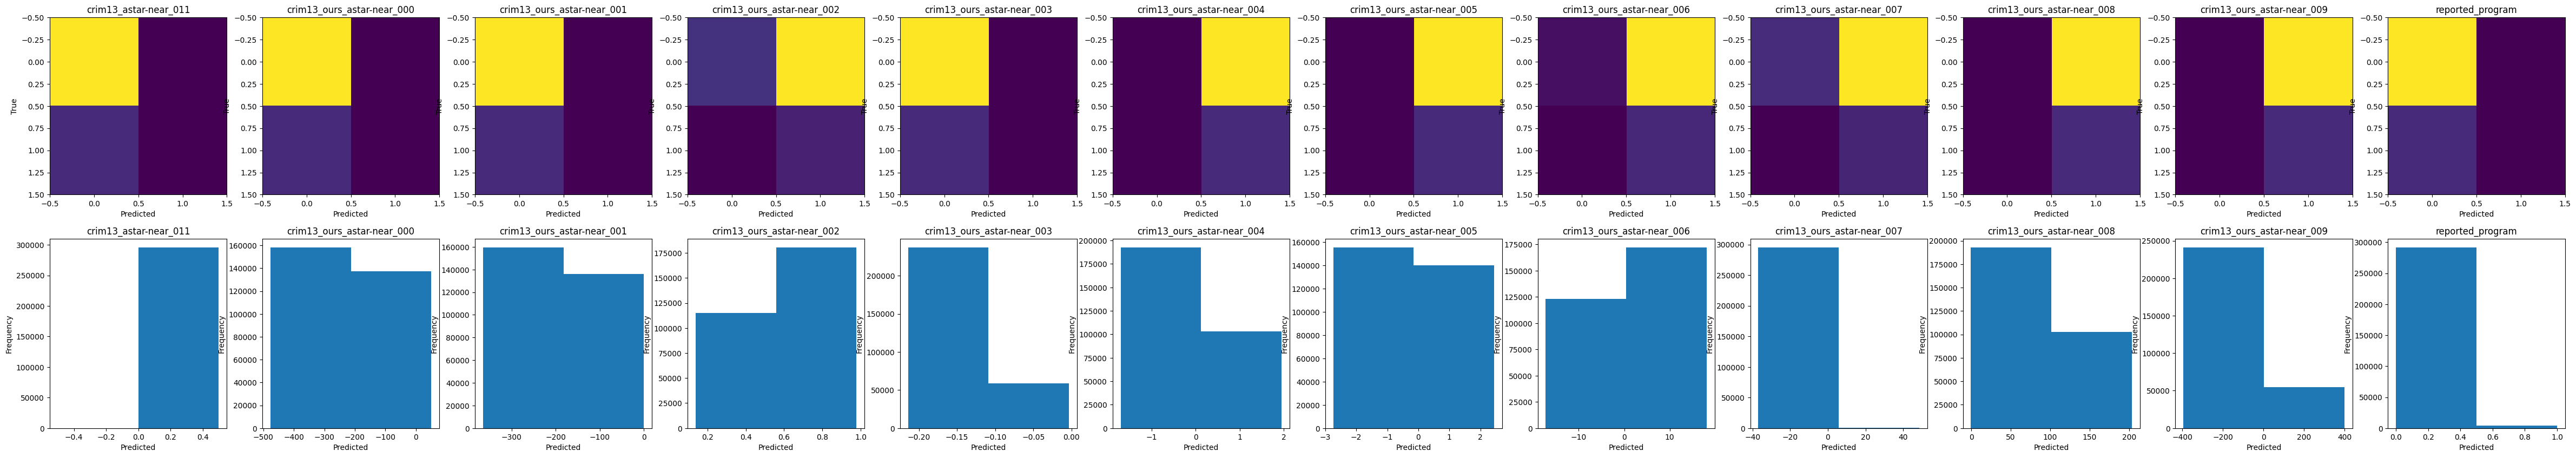

In [ ]:
# verify that all_results[k]['true_vals'] are the same
# for k in all_results:
#     assert all_results[k]['true_vals'] == all_results['crim13_iddfs-near_001']['true_vals']

# construct N confusion matrices
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
for k in all_results:
    confusion_matrices[k] = confusion_matrix(
        all_results[k]["true_vals"],
        threshold_predictions(
            y_scores=torch.tensor(all_results[k]["pred_vals"]),
            y_true=torch.tensor(all_results[k]["true_vals"]),
        ),
    )

# plot the confusion matrices


fig, axs = plt.subplots(
    2, len(confusion_matrices), figsize=(5 * len(confusion_matrices), 10)
)

for i, k in enumerate(confusion_matrices):
    axs[0][i].imshow(confusion_matrices[k], cmap="viridis")
    axs[0][i].set_title(k)
    axs[0][i].set_xlabel("Predicted")
    axs[0][i].set_ylabel("True")

# on axs[1] plot the histogram of the predictions
for i, k in enumerate(confusion_matrices):
    axs[1][i].hist(all_results[k]["pred_vals"], bins=2)
    axs[1][i].set_title(k)
    axs[1][i].set_xlabel("Predicted")
    axs[1][i].set_ylabel("Frequency")


fig.savefig("outputs/mice_results/confusion_matrices.png", bbox_inches="tight")

In [10]:
all_reports = {}
for k in all_results:
    all_reports[k] = all_results[k]["report"]["report"]
    all_reports[k]["macro avg"]["time"] = (
        all_results[k]["time"] if "time" in all_results[k] else 0
    )
    all_reports[k]["macro avg"]["acc"] = all_results[k]["report"]["hamming_accuracy"]


all_reports = {k: all_reports[k]["macro avg"] for k in all_reports}
df = pd.DataFrame(all_reports).T
print(df.to_markdown())
# df.to_csv("outputs/mice_results/crim13_results.csv")


|                            |   precision |   recall |   f1-score |   support |    time |      acc |
|:---------------------------|------------:|---------:|-----------:|----------:|--------:|---------:|
| crim13_astar-near_011      |    0.446849 | 0.5      |  0.471933  |    295300 | 852.341 | 0.893698 |
| crim13_ours_astar-near_000 |    0.446849 | 0.5      |  0.471933  |    295300 | 112.097 | 0.893698 |
| crim13_ours_astar-near_001 |    0.446849 | 0.5      |  0.471933  |    295300 | 112.097 | 0.893698 |
| crim13_ours_astar-near_002 |    0.48771  | 0.483668 |  0.215422  |    295300 | 112.097 | 0.2168   |
| crim13_ours_astar-near_003 |    0.446849 | 0.5      |  0.471933  |    295300 | 112.097 | 0.893698 |
| crim13_ours_astar-near_004 |    0.053151 | 0.5      |  0.0960877 |    295300 | 112.097 | 0.106302 |
| crim13_ours_astar-near_005 |    0.053151 | 0.5      |  0.0960877 |    295300 | 112.097 | 0.106302 |
| crim13_ours_astar-near_006 |    0.483296 | 0.491861 |  0.138658  |    295300 | 1

In [ ]:
# all_reports = {}
# for k in all_results:
#     all_reports[k] = all_results[k]["report"]["report"]
#     all_reports[k]["macro avg"]["time"] = (
#         all_results[k]["time"] if "time" in all_results[k] else 0
#     )
#     all_reports[k]["macro avg"]["acc"] = all_results[k]["report"]["hamming_accuracy"]


# all_reports = {k: all_reports[k]["macro avg"] for k in all_reports}
# df = pd.DataFrame(all_reports).T
# print(df.to_markdown())
# # df.to_csv("outputs/mice_results/crim13_results.csv")


|                            |   precision |   recall |   f1-score |   support |      time |      acc |
|:---------------------------|------------:|---------:|-----------:|----------:|----------:|---------:|
| crim13_iddfs-near_010      |    0.446849 | 0.5      |   0.471933 |    295300 | 61754.9   | 0.893698 |
| crim13_astar-near_010      |    0.446849 | 0.5      |   0.471933 |    295300 | 44204     | 0.893698 |
| crim13_enumeration_010     |    0.446849 | 0.5      |   0.471933 |    295300 | 81125.3   | 0.893698 |
| crim13_ours_astar-near_000 |    0.446849 | 0.5      |   0.471933 |    295300 |   114.481 | 0.893698 |
| crim13_ours_astar-near_001 |    0.488855 | 0.47607  |   0.29952  |    295300 |   114.481 | 0.322015 |
| crim13_ours_astar-near_002 |    0.49722  | 0.499617 |   0.480105 |    295300 |  1048.75  | 0.883105 |
| crim13_ours_astar-near_003 |    0.49722  | 0.499617 |   0.480105 |    295300 |  1048.75  | 0.883105 |
| crim13_ours_astar-near_004 |    0.446849 | 0.5      |   0.4719

In [ ]:
# all_reports = {}
# for k in all_results:
#     all_reports[k] = all_results[k]["report"]["report"]
#     all_reports[k]["macro avg"]["time"] = (
#         all_results[k]["time"] if "time" in all_results[k] else 0
#     )
#     all_reports[k]["macro avg"]["acc"] = all_results[k]["report"]["hamming_accuracy"]


# all_reports = {k: all_reports[k]["macro avg"] for k in all_reports}
# df = pd.DataFrame(all_reports).T
# print(df.to_markdown())
# df.to_csv("outputs/mice_results/crim13_results.csv")


|                            |   precision |   recall |   f1-score |   support |       time |      acc |
|:---------------------------|------------:|---------:|-----------:|----------:|-----------:|---------:|
| crim13_iddfs-near_010      |    0.446849 | 0.5      |  0.471933  |    295300 | 61754.9    | 0.893698 |
| crim13_astar-near_010      |    0.446849 | 0.5      |  0.471933  |    295300 | 44204      | 0.893698 |
| crim13_enumeration_010     |    0.446849 | 0.5      |  0.471933  |    295300 | 81125.3    | 0.893698 |
| crim13_ours_astar-near_000 |    0.494009 | 0.496733 |  0.491333  |    295300 |    41.1074 | 0.849306 |
| crim13_ours_astar-near_001 |    0.49967  | 0.499976 |  0.476864  |    295300 |    43.4796 | 0.888212 |
| crim13_ours_astar-near_002 |    0.49967  | 0.499976 |  0.476864  |    295300 |    43.4797 | 0.888212 |
| crim13_ours_astar-near_003 |    0.053151 | 0.5      |  0.0960877 |    295300 |    43.4797 | 0.106302 |
| crim13_ours_astar-near_004 |    0.492839 | 0.499097 |

In [ ]:
# In [31]: print_program(best_program, ignore_constants=False)
# Out[31]: "Start(MapPrefixes(Window5Avg(Multiply(DistanceSelect(params: dict_values([
# Parameter containing:\ntensor([[-0.2597]], device='cuda:0', requires_grad=True), Par
# ameter containing:\ntensor([0.7555], device='cuda:0', requires_grad=True)])), Simple
# ITE(DistanceChangeSelect(params: dict_values([Parameter containing:\ntensor([[-0.000
# 7]], device='cuda:0', requires_grad=True), Parameter containing:\ntensor([0.5469], d
# evice='cuda:0', requires_grad=True)])), DistanceSelect(params: dict_values([Paramete
# r containing:\ntensor([[0.0007]], device='cuda:0', requires_grad=True), Parameter co
# ntaining:\ntensor([-0.2967], device='cuda:0', requires_grad=True)])), DistanceChange
# Select(params: dict_values([Parameter containing:\ntensor([[-0.0003]], device='cuda:
# 0', requires_grad=True), Parameter containing:\ntensor([0.4114], device='cuda:0', re
# quires_grad=True)])))))))"

# In [32]: print_program(best_program, ignore_constants=True)
# Out[32]: 'Start(MapPrefixes(Window5Avg(Multiply(DistanceSelect(), SimpleITE(Distance
# ChangeSelect(), DistanceSelect(), DistanceChangeSelect())))))'

In [18]:
df

,precision,recall,f1-score,support,time,acc
crim13_astar-near_003,0.615180,0.709285,0.632807,295300.0,15401.349342,0.798561
crim13_iddfs-near_003,0.616762,0.673433,0.634113,295300.0,61701.472831,0.825733
crim13_ours_astar-near_000,0.494009,0.496733,0.491333,295300.0,41.107355,0.849306
crim13_ours_astar-near_001,0.499670,0.499976,0.476864,295300.0,43.479608,0.888212
crim13_ours_astar-near_002,0.499670,0.499976,0.476864,295300.0,43.479672,0.888212
crim13_ours_astar-near_003,0.053151,0.500000,0.096088,295300.0,43.479706,0.106302
crim13_ours_astar-near_004,0.492839,0.499097,0.478559,295300.0,43.479746,0.883806
crim13_ours_astar-near_005,0.525263,0.507341,0.126161,295300.0,44.830552,0.131463
crim13_ours_astar-near_006,0.473906,0.431391,0.382497,295300.0,44.830594,0.485466
crim13_ours_astar-near_007,0.511585,0.506867,0.154254,295300.0,46.845002,0.156075


In [ ]:
#  - NEAR codebase rerun with correct prediction metrics.
#  - Ask Jen if she still has her codebase / if they had a "non-camera ready" codebase.
#       - How to setup the reported_program search problem?
#  - Change training setup in neurosym-lib with (1) early stopping and (2) scheduler.
# otherwise, try to give the same time budget while finding candidate programs with neurosym-lib.


In [ ]:
# Calculate our own performance metrics.
# Retrain the weights of the reported programs.

# What metrics should we use for unbalanced datasets?
# top-k accuracy.
# - Pick the smaller class and do top-k accuracy on that.
# - invariant to model calibration
# Let's redo training with top-k accuracy.
